# 특징간 높은 상관성 문제
---
- 회귀모델, 신경망, SVM과 같이 wx + b 형태의 `선형식이 모델에 포함`되는 경우, 특징간 상관성이 높으면 파라미터를 수정할때마다 결과가 달라질 수 있다.
---
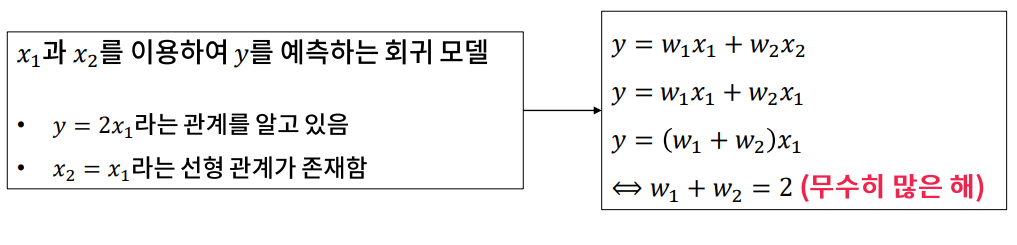

---
- w1 + w2 를 예측할 수 있는 경우의 수가 무수히 많기 때문에 특징간 상관성이 높은 경우 예측 결과가 매번 달라질 수 있다.
- 추가로 회귀모델의 경우 잔차제곱을 최소화하기 위해 미분이 들어가는데, 미분시 결과식에 역행렬이 들어간다.
- 이때 특징간 상관성이 높으면 `역행렬` 자체가 구해지지 않을 수 있어 예측 결과치를 구하지 못할 수 있다.
---

# Tree 계열 모델과 높은 상관성문제
---
- Tree 계열 모델들은 특징간 상관관계가 높다고 모델 예측 성능에 영향을 받지는 않는다.
- 하지만, 위의 경우 처럼 `x2 = x1` 과 같은 관계가 특징간에 존재하면, 설명력에 영향을 미치게 된다.
- x1을 특징으로 분류하든, x2를 특징으로 분류하든 결과는 같기 때문에 임의로 값을 선택하게 되기 때문이다.
- 만약 x1을 선택하면, x2는 선택하지 않게 되어 해당 특징이 모델에 어떤 영향을 미치는지가 반영되지 않는다.
---

- 추가적으로 x2 = x1 과 같은 특징간 선형 관계가 있을 경우, 둘중 하나의 변수만 써도 되는데도 2개의 변수를 모두 사용하면 필요 이상의 계산량이 발생하는 문제점도 있다.

# 특징간 높은 상관성 문제 해결 방법 (1) - VIF 활용
---
- VIF(Variance inflation factors, 분산 팽창 계수) : 한 특징을 라벨로 간주하고, 해당 라벨을 예측하는데 다른 특징들이 얼마나 영향을 미치는지를 나타내는 지표
- VIF 지수는 사용된 회귀모델의 R_squared 가 높은 경우 해당 특징이 다른 특징과 상관성이 있다고 판단한다.
- R_squared는 0 ~ 1 사이의 값을 가지며, 1에 가까울 수록 좋은 모델이라고 한다.
- 일반적으로 VIF > 10 이면 삭제한다. 
- 혹은 VIF가 높은 순서대로 특징을 순차적으로 제거하면서 모델 성능을 비교해 보기도 한다.
---

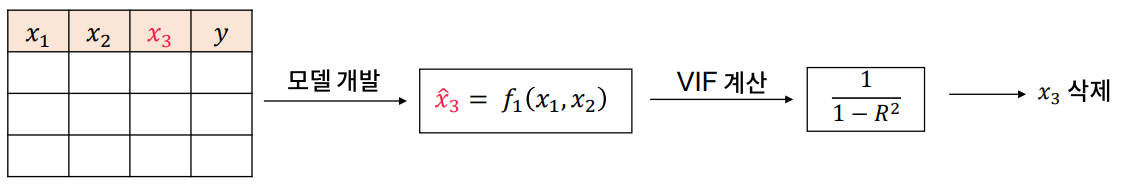

---

In [1]:
import os
import pandas as pd

# 불필요한 경고 표시 생략
import warnings
warnings.filterwarnings(action = 'ignore')

a=%pwd # 현재 경로 a에 할당
os.chdir(a) # 파일 로드 경로 설정

실습 데이터 불러오기

In [2]:
df = pd.read_csv("abalone.csv")
df.head()

,Length,Diameter,Height,Wholeweight,Shuckedweight,Visceraweight,Shellweight,Age
0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


In [3]:
# 특징과 라벨 분리
X = df.drop(['Age'], axis = 1)
Y = df['Age']

In [4]:
# 학습 데이터와 평가 데이터 분리
from sklearn.model_selection import train_test_split
Train_X, Test_X, Train_Y, Test_Y = train_test_split(X, Y)

In [5]:
Train_X.corr() # 특징 간 상관 행렬 출력

,Length,Diameter,Height,Wholeweight,Shuckedweight,Visceraweight,Shellweight
Length,1.000000,0.986837,0.804964,0.923764,0.897827,0.900123,0.895734
Diameter,0.986837,1.000000,0.811648,0.924737,0.893641,0.897403,0.904056
Height,0.804964,0.811648,1.000000,0.799318,0.756601,0.777765,0.796511
Wholeweight,0.923764,0.924737,0.799318,1.000000,0.969840,0.965907,0.956275
Shuckedweight,0.897827,0.893641,0.756601,0.969840,1.000000,0.932337,0.883684
Visceraweight,0.900123,0.897403,0.777765,0.965907,0.932337,1.000000,0.906580
Shellweight,0.895734,0.904056,0.796511,0.956275,0.883684,0.906580,1.000000


- 대부분의 값이 0.8 이상으로 1에 매우 가깝다. 
- 즉, 특징간 상관성이 매우 크다는 것을 알 수 있다.

## VIF 기준 특징 선택

In [6]:
# VIF 계산(LR 모델로 특징 학습 -> 예측)
from sklearn.linear_model import LinearRegression as LR

# 결과 저장용 dict
VIF_dict = dict()

for col in Train_X.columns:
    # 특정 컬럼(Train_X[col])을 label로 놓고, label 컬럼을 제외한 나머지값을 feature로 지정해서 LR모델에 fitting
    model = LR().fit(Train_X.drop([col], axis = 1), Train_X[col])
    
    # model의 score 계산
    r2 = model.score(Train_X.drop([col], axis = 1), Train_X[col]) # LinearRegression의 score가 r2 점수임
    
    # VIF 계산
    VIF = 1 / (1 - r2)
    
    # column을 key, VIF값을 value로 하는 dict생성
    VIF_dict[col] = VIF

In [7]:
VIF_dict

{'Length': 40.68621635447305,
 'Diameter': 42.051119629723004,
 'Height': 3.1521534924577703,
 'Wholeweight': 117.11182064887532,
 'Shuckedweight': 29.86691542487379,
 'Visceraweight': 17.391077031247498,
 'Shellweight': 22.559683775471154}

- Height를 제외하곤 VIF가 모두 10이상으로 높다.
- 원칙적으로는 Height를 제외하고 나머지는 다 drop해야 한다.
- 하지만 그렇게 되면, 모델에 활용할 데이터가 전부 사라진다.
- **따라서, 이러한 상황에서는 사실 PCA를 사용하는 것이 바람직하다.**

In [8]:
from sklearn.neural_network import MLPRegressor as MLP
from sklearn.metrics import mean_absolute_error as MAE

### VIF  삭제 없이 모든 특징 사용할 때

In [9]:
model = MLP(random_state = 2313, max_iter = 500) 
model.fit(Train_X, Train_Y)
pred_Y = model.predict(Test_X)
score = MAE(Test_Y, pred_Y)
print(score)

1.6762241896902343


### VIF < 30 인 특징만 사용할 때

In [10]:
selected_features = [key for key, val in VIF_dict.items() if val < 30] 
model = MLP(random_state = 2313, max_iter = 500)
model.fit(Train_X[selected_features], Train_Y)
pred_Y = model.predict(Test_X[selected_features])
score = MAE(Test_Y, pred_Y)
print(score)

1.6292545451829068


4개의 특징만을 사용했지만, 전체 데이터를 사용한 것보다 성능이 더 높아진 것을 확인할 수 있다.

---

# 특징간 높은 상관성 문제 해결 방법 (2) - PCA 활용
---
- 주성분 분석을 의미
- PCA를 통해 특징이 서로 직교 하도록 만들어 특징간 상관성을 줄이는 방법
---

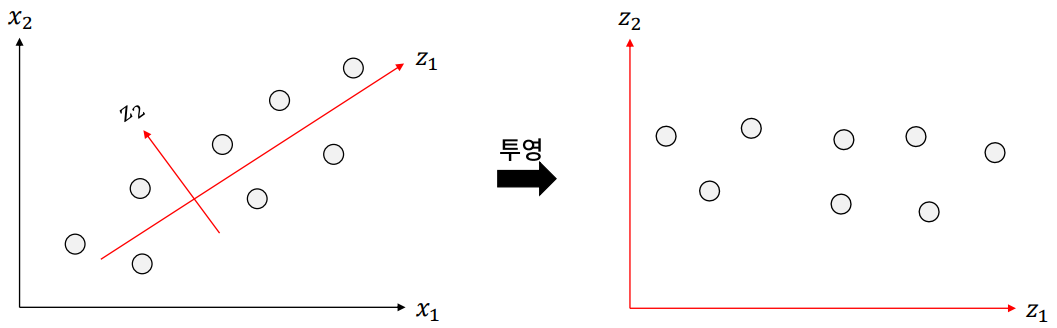

---
- n차원의 데이터는 총 n개의 주성분이 존재한다.
- 이때, 차원 축소를 위해 분산의 대부분을 설명하는 주성분만을 추려서 사용한다. 
---
위의 그림을 기준으로 보자면

- 기존의 차원이 x1, x2라는 2개의 차원으로 이루어져 있다.
- 원본 데이터를 원본 특징이 아닌 새로운 차원에 데이터를 `투영` 시킨다.
- 위 그림 처럼 z1 방향으로 움직이는 데이터와, z2 방향으로 움직이는 데이터를 z1, z2라는 새로운 차원상의 그래프로 투영하여 다시 표현한다.
- z1이 z2보다는 데이터의 분산을 더 잘 표현한다.
---

## 관련 문법 : sklearn.decomposition.PCA
---

- 주성분 분석을 수행하는 모델을 생성하는 함수

**파라미터**

---
- n_components : 사용할 주성분 개수 (무조건 기존 차원 수보다는 작아야 한다.)

**주요 attribute**
- .explained_variance_ratio_ : 각 주성분이 원본 데이터의 분산을 설명하는 정도

In [11]:
from sklearn.decomposition import PCA

#모델 생성 (3개의 주성분으로 데이터 변경) & fitting
PCA_model = PCA(n_components = 3).fit(Train_X)

# train / test에 transform
Train_Z = PCA_model.transform(Train_X)
Test_Z = PCA_model.transform(Test_X)

print(Train_Z.shape)

(3132, 3)


차원값이 3으로 줄어든 것을 확인할 수 있다.

## PCA 적용한 모델 성능 평가

In [12]:
model = MLP(random_state = 2313, max_iter = 500)
model.fit(Train_Z, Train_Y)
pred_Y = model.predict(Test_Z)
score = MAE(Test_Y, pred_Y)
print(score)

1.5539611901118482


위의 VIF 방식에서 특징 제거없이 진행한 모델의 성능 (약 1.67) 보다 더 나아진 결과를 확인할 수 있다.